# Exploring Kicker Average and Consistency

The ability to perform well in individual matches at critical moments is important, but consistently performing at a high level of skill creates a statistical divide between lucky players and highly skilled players. As a result, measuring empirical variance is an important aspect to determining a player’s skill level.

## Prepare Data

Get kickers play data from data base with play, player and game information
(where distance kicked from is >=35 yards)

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

config = {
'user': 'db_gtown_2018',
'password': 'Gtown2018',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT 
    FKICKER,
    Percentage.GID,
    FGXP,
    ((SUM(SUCCESS) / COUNT(*)) * 100) AS SUCCESS_PRCNTG,
    ((SUM(BLOCKED) / COUNT(*)) * 100) AS BLOCKED_PRCNTG,
    COUNT(*) AS PLAY_COUNT,
    CASE
        WHEN SUM(HIGH_PRESSURE) = 0 THEN 0
        ELSE ((SUM(HIGH_PRESSURE_SUCCESS) / SUM(HIGH_PRESSURE)) * 100)
    END AS HIGH_PRESSURE_SUCCESS_PRCNTG,
    CASE
        WHEN SUM(LONG_DIST) = 0 THEN 0
        ELSE ((SUM(LONG_DIST_SUCCESS) / SUM(LONG_DIST)) * 100)
    END AS LONG_DIST_SUCCESS_PRCNTG,    
    TEMP,
    HUMD,
    WSPD,
    COND,
    SURF,
    (YEAR(CURDATE()) - PLAYER.start) AS YEARS_PLAYED,
    height,
    weight,
    PLAYER.forty,
    PLAYER.bench,
    PLAYER.vertical,
    PLAYER.broad,
    PLAYER.shuttle,
    PLAYER.cone,
    PLAYER.arm,
    PLAYER.hand,
    PLAYER.dcp,
    DPOS AS DRAFT_POSITION,
    (SELECT 
            (TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE(dob, '%m/%d/%Y'))) / 365
        FROM
            PLAYER P
        WHERE
            P.player = FKICKER) AS AGE_YEARS
FROM
    (SELECT 
        FGXP,
            PBP.GID,
            PBP.FKICKER,
            CASE
                WHEN GOOD = 'Y' THEN 1
                ELSE 0
            END AS SUCCESS,
            CASE
                WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1
                ELSE 0
            END AS BLOCKED,
            CASE
                WHEN
                    QTR IN ('2' , '4') AND MIN <= 2
                        AND (PTSO - PTSD) >= - 3
                THEN
                    1
                ELSE 0
            END AS HIGH_PRESSURE,
            CASE
                WHEN
                    QTR IN ('2' , '4') AND MIN <= 2
                        AND (PTSO - PTSD) >= - 3
                        AND GOOD = 'Y'
                THEN
                    1
                ELSE 0
            END AS HIGH_PRESSURE_SUCCESS,
            CASE
                WHEN DIST >= 50 THEN 1
                ELSE 0
            END AS LONG_DIST,
            CASE
                WHEN DIST >= 50 AND GOOD = 'Y' THEN 1
                ELSE 0
            END AS LONG_DIST_SUCCESS,
            DIST - (100 - CASE
                WHEN YFOG = '' THEN '98'
                ELSE YFOG
            END) AS YDS_BEHIND_LOS
    FROM
        PBP
    LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
    WHERE
        TYPE = 'FGXP' AND POS1 = 'K'
            AND DIST >= 35) AS Percentage
        LEFT OUTER JOIN
    PLAYER PLAYER ON Percentage.FKICKER = PLAYER.PLAYER
        LEFT OUTER JOIN
    GAME ON Percentage.GID = GAME.GID
GROUP BY FKICKER , Percentage.GID
ORDER BY FKICKER , Percentage.GID;"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [2]:
df.columns = ['FKICKER','GID','FGXP','SUCCESS_PRCNTG','BLOCKED_PRCNTG','PLAY_COUNT',
'HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG',
'TEMP','HUMD','WSPD','COND','SURF',
'YEARS_PLAYED','height','weight','forty','bench',
'vertical','broad','shuttle','cone',
'arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']

In [3]:
df.head(3)

,FKICKER,GID,FGXP,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG,TEMP,HUMD,...,bench,vertical,broad,shuttle,cone,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS
0,AD-0800,14,FG,100.0000,0.0000,1,0,0,73,78,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.2219
1,AD-0800,28,FG,100.0000,0.0000,1,0,0,80,84,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.2219
2,AD-0800,54,FG,100.0000,0.0000,2,0,0,61,0,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.2219


## Weather conditions

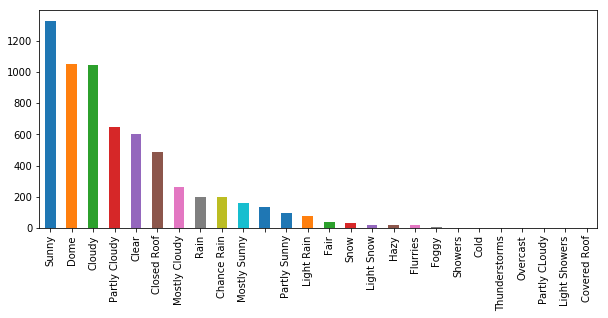

In [4]:
plt.figure(figsize=(10,4))
df["COND"].value_counts().plot(kind='bar')

too many weather conditions, grouping these in fewer categories.

In [5]:
WeatherConditionsDifficultyLevel = {
    'unknown_weather': '',
    'normal_weather':['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
              'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
              'Sunny','Mostly Sunny','Partly Sunny'],
    'hard_weather':['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'extreme_weather':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
               'Windy','Overcast']
}

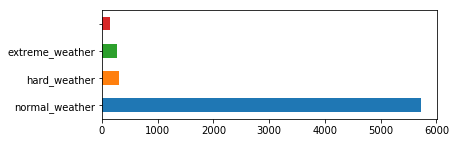

In [6]:
def get_weather_category(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
dfc = df.apply(lambda row: get_weather_category(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
df["WeatherCondition"] = dfc
plt.figure(figsize=(6,2))
df["WeatherCondition"].value_counts().plot(kind='barh')

In [7]:
df["WeatherCondition"].value_counts()

normal_weather     5721
hard_weather        308
extreme_weather     262
                    137
Name: WeatherCondition, dtype: int64

Now let's create dummy column for each weather category and then use these column to get success percentage in each category.

In [8]:
ddf=pd.concat([df,pd.get_dummies(df["WeatherCondition"])], axis=1)

In [9]:
ddf.head(3)

,FKICKER,GID,FGXP,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG,TEMP,HUMD,...,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS,WeatherCondition,,extreme_weather,hard_weather,normal_weather
0,AD-0800,14,FG,100.0000,0.0000,1,0,0,73,78,...,0,0.0,0,0,56.2219,normal_weather,0,0,0,1
1,AD-0800,28,FG,100.0000,0.0000,1,0,0,80,84,...,0,0.0,0,0,56.2219,normal_weather,0,0,0,1
2,AD-0800,54,FG,100.0000,0.0000,2,0,0,61,0,...,0,0.0,0,0,56.2219,hard_weather,0,0,1,0


## Calculate averages and consistency ratings
For averages we can consider/use player mean success percentage in each game.<br/>
To measure player consistency, we borrow a concept from probability theory called the coefficient of variation (CV). This measures a player’s standardized performance dispersion. Since this is a rather large and normal sample, this model uses the unbiased form of the coefficient of variation equation:

(1+1/4n)(Std_dev/mean)

The result of this means that lower CV values result in less variation in performance, indicating a higher degree of consistency. As the CV increases, players become less and less consistent. This means we now have an empirical range with which we can determine the ability of players to perform consistently at a given level of performance.

In [10]:
# Check number of missing values
ddf.isnull().sum()

FKICKER                         0
GID                             0
FGXP                            0
SUCCESS_PRCNTG                  0
BLOCKED_PRCNTG                  0
PLAY_COUNT                      0
HIGH_PRESSURE_SUCCESS_PRCNTG    0
LONG_DIST_SUCCESS_PRCNTG        0
TEMP                            0
HUMD                            0
WSPD                            0
COND                            0
SURF                            0
YEARS_PLAYED                    0
height                          0
weight                          0
forty                           0
bench                           0
vertical                        0
broad                           0
shuttle                         0
cone                            0
arm                             0
hand                            0
dcp                             0
DRAFT_POSITION                  0
AGE_YEARS                       0
WeatherCondition                0
                                0
extreme_weathe

In [11]:
ddf.columns

Index(['FKICKER', 'GID', 'FGXP', 'SUCCESS_PRCNTG', 'BLOCKED_PRCNTG',
       'PLAY_COUNT', 'HIGH_PRESSURE_SUCCESS_PRCNTG',
       'LONG_DIST_SUCCESS_PRCNTG', 'TEMP', 'HUMD', 'WSPD', 'COND', 'SURF',
       'YEARS_PLAYED', 'height', 'weight', 'forty', 'bench', 'vertical',
       'broad', 'shuttle', 'cone', 'arm', 'hand', 'dcp', 'DRAFT_POSITION',
       'AGE_YEARS', 'WeatherCondition', '', 'extreme_weather', 'hard_weather',
       'normal_weather'],
      dtype='object')

In [12]:
cdf= ddf[['FKICKER','PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']]
cdf[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']] = cdf[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']].apply(pd.to_numeric)
cdf.head(3)

c:\users\deepak\anaconda3\envs\gtulab\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,FKICKER,PLAY_COUNT,SUCCESS_PRCNTG,BLOCKED_PRCNTG,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG
0,AD-0800,1,100.0,0.0,0.0,0.0
1,AD-0800,1,100.0,0.0,0.0,0.0
2,AD-0800,2,100.0,0.0,0.0,0.0


In [40]:
def filterData(ch=0, count=0,cond=0):
    global result
    plt.figure(figsize=(22,8))
    
    if(ch=='Any'):
        result = cdf.groupby(['FKICKER'], as_index=False).agg(
            {'PLAY_COUNT':['sum'],'SUCCESS_PRCNTG':['mean','std']})
        result.columns = ['FKICKER','PLAY_COUNT','SUCCESS_PRCNTG_MEAN','SUCCESS_PRCNTG_STD']
        result.reindex(columns=sorted(result.columns))
        result = result[result['PLAY_COUNT']>count]
        result['SUCCESS_PRCNTG_CV'] = result['SUCCESS_PRCNTG_STD']/result['SUCCESS_PRCNTG_MEAN']
        plt.plot(result['SUCCESS_PRCNTG_MEAN'], result['SUCCESS_PRCNTG_CV'], 'ro')
        #xy_chart.add('Player', [(row.SUCCESS_PRCNTG_MEAN,row.SUCCESS_PRCNTG_CV) for index,row in result.iterrows()])
        

    elif(ch=='Long Distance'):
        result = cdf.groupby(['FKICKER'], as_index=False).agg(
            {'PLAY_COUNT':['sum'],'LONG_DIST_SUCCESS_PRCNTG':['mean','std']})
        result.columns = ['FKICKER','PLAY_COUNT','LONG_DIST_SUCCESS_PRCNTG_MEAN','LONG_DIST_SUCCESS_PRCNTG_STD']
        result.reindex(columns=sorted(result.columns))
        result = result[result['PLAY_COUNT']>count]
        result['LONG_DIST_SUCCESS_PRCNTG_CV'] = result['LONG_DIST_SUCCESS_PRCNTG_STD']/result['LONG_DIST_SUCCESS_PRCNTG_MEAN']
        plt.plot(result['LONG_DIST_SUCCESS_PRCNTG_MEAN'], result['LONG_DIST_SUCCESS_PRCNTG_CV'], 'ro')

    elif(ch=='High Pressure'):
        result = cdf.groupby(['FKICKER'], as_index=False).agg(
            {'PLAY_COUNT':['sum'],'HIGH_PRESSURE_SUCCESS_PRCNTG':['mean','std']})
        result.columns = ['FKICKER','PLAY_COUNT','HIGH_PRESSURE_SUCCESS_PRCNTG_MEAN','HIGH_PRESSURE_SUCCESS_PRCNTG_STD']
        result.reindex(columns=sorted(result.columns))
        result = result[result['PLAY_COUNT']>count]
        result['HIGH_PRESSURE_SUCCESS_PRCNTG_CV'] = result['HIGH_PRESSURE_SUCCESS_PRCNTG_STD']/result['HIGH_PRESSURE_SUCCESS_PRCNTG_MEAN']
        plt.plot(result['HIGH_PRESSURE_SUCCESS_PRCNTG_MEAN'], result['HIGH_PRESSURE_SUCCESS_PRCNTG_CV'], 'ro')
    
    #plt.axis([40, 100.5, -.01, 1])
    plt.show()
    

In [41]:
c=interactive(filterData,ch=['Any','High Pressure', 'Long Distance'],
              count=(0,100,1),cond=['Any', 'Normal', 'Hard', 'Extreme'])
display(c)

interactive(children=(Dropdown(description='ch', options=('Any', 'High Pressure', 'Long Distance'), value='Any'), IntSlider(value=0, description='count'), Dropdown(description='cond', options=('Any', 'Normal', 'Hard', 'Extreme'), value='Any'), Output()), _dom_classes=('widget-interact',))

In [21]:
%matplotlib inline
from IPython.display import SVG, HTML

In [22]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>    
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [38]:
import pygal
xy_chart = pygal.XY(stroke=False,tooltip_border_radius=10)
xy_chart.title = 'Correlation'
xy_chart.add('Player', [(1,1),(2,2)])
HTML(html_pygal.format(pygal_render=xy_chart.render(is_unicode=True)))
